# Additional  Insights

---
**Group 2:**

- Luis Mendes 20221949
- Margarida Ourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945
---

### **Abstract**
Here we want to test  whether  the  best  performance  is  achieved  using  a  general  model(trained using data from all brands/models, etc...) or pecific brands


**Table of contents**<a id='toc0_'></a> 
- [Imports](#toc2_)    
- [Data Integration](#toc3_)    
- [Modeling](#toc4_)    
    - [KNN](#toc4_1_1_)    
    - [Random Forest](#toc4_1_2_)    
    - [NN](#toc4_1_3_)    
- [Deployment](#toc5_)    
    - [Prediction](#toc5_1_2_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [54]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Grid Search
from sklearn.model_selection import ParameterGrid
# Progress
from tqdm import tqdm
# Spliting
from sklearn.model_selection import KFold
# Preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Imputation
from sklearn.impute import KNNImputer
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# CV Score and Graphing
from utils import (avg_scores,
                   graph_actual_vs_predicted, 
                   model_performance, 
                   grid_score, 
                   print_cv_results)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

# KNN

## Uploading data

In [55]:
# Load your cleaned (NOT encoded/scaled) dataset
X_M, y_M = pd.read_pickle('../project_data/X_Ylog_ModelOptimization.pkl')

# Ensure indexes match
X_M = X_M.reset_index(drop=True)
y_M = y_M.reset_index(drop=True)

brands = X_M['Brand'].unique()
brands = np.sort(brands)

Final data preprocessing to avoid data leackage

In [56]:
brand_preprocessed = {}   # store all objects and preprocessed data

for brand in brands:
    print(f"--- Processing brand: {brand} ---")
    
    # 1. Extract brand-specific rows to ensure no data leakage
    mask = (X_M['Brand'] == brand)
    X_b = X_M.loc[mask].reset_index(drop=True).copy()
    y_b = y_M.loc[mask].reset_index(drop=True).copy()
    
    # Drop Brand for preprocessing
    X_b_no_brand = X_b.drop(columns=['Brand'])
    
    # Train/validation split for brand (local)
    from sklearn.model_selection import train_test_split
    Xb_train, Xb_test, yb_train, yb_test = train_test_split(
        X_b_no_brand, y_b, test_size=0.20, random_state=42
    )
    # impute categorial variables
    if 'transmission' in Xb_train.columns:
            # Find mode to fill
        transmission_mode = Xb_train['transmission'].mode()[0]
    else:
        transmission_mode = None
    
    if transmission_mode is not None:
            # Fill on train and test
        Xb_train['transmission'] = Xb_train['transmission'].fillna(transmission_mode)
        Xb_test['transmission']  = Xb_test['transmission'].fillna(transmission_mode)
    
    # Define the Encoding for Categorical Variables
    ohe = OneHotEncoder(
        categories=[['automatic', 'manual', 'semi-auto']],
        drop=['automatic'],
        handle_unknown='ignore',
        sparse_output=False,
        dtype=int
    )
    
    preproc = ColumnTransformer(
        transformers=[
        # (name, transformer_object, [list_of_columns])
            ('enc_trans', ohe, ['transmission'])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    preproc.set_output(transform='pandas')
    
    # Fit on TRAIN only
    Xb_train_enc = preproc.fit_transform(Xb_train)
    Xb_test_enc  = preproc.transform(Xb_test)
    
    # Sacle with RobustScaler
    scaler = RobustScaler()
    Xb_train_scaled = scaler.fit_transform(Xb_train_enc)
    Xb_test_scaled  = scaler.transform(Xb_test_enc)
    
    # Impute
    imputer = KNNImputer(n_neighbors=10, weights='uniform')
    Xb_train_imp = imputer.fit_transform(Xb_train_scaled)
    Xb_test_imp  = imputer.transform(Xb_test_scaled)
    
    # Convert back to DataFrames + reattach brand
    Xb_train_final = pd.DataFrame(Xb_train_imp, columns=Xb_train_enc.columns)
    Xb_test_final  = pd.DataFrame(Xb_test_imp, columns=Xb_test_enc.columns)
    
    Xb_train_final['Brand'] = brand
    Xb_test_final['Brand']  = brand
    
    # Store everything in dictionary
    brand_preprocessed[brand] = {
        'X_train': Xb_train_final,
        'X_test':  Xb_test_final,
        'y_train': yb_train,
        'y_test':  yb_test,
        'encoder': preproc,
        'scaler':  scaler,
        'imputer': imputer,
        'transmission_mode': transmission_mode
    }

--- Processing brand: audi ---
--- Processing brand: bmw ---
--- Processing brand: ford ---
--- Processing brand: bmw ---
--- Processing brand: ford ---
--- Processing brand: hyundai ---
--- Processing brand: mercedes ---
--- Processing brand: hyundai ---
--- Processing brand: mercedes ---
--- Processing brand: opel ---
--- Processing brand: opel ---
--- Processing brand: skoda ---
--- Processing brand: toyota ---
--- Processing brand: vw ---
--- Processing brand: skoda ---
--- Processing brand: toyota ---
--- Processing brand: vw ---


Some vizualizations for better understanding data disctribution between brands

Sample count per brand:


,Brand,Samples
2,ford,15673
4,mercedes,11382
8,vw,10121
5,opel,9134
1,bmw,7214
0,audi,7147
7,toyota,4519
6,skoda,4194
3,hyundai,3261


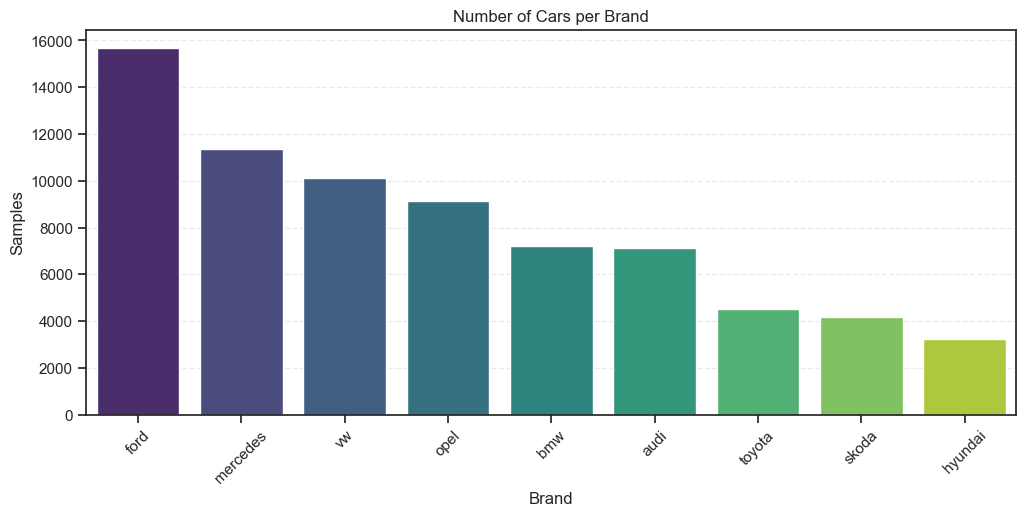

In [57]:
brand_sizes = {brand: brand_preprocessed[brand]['X_train'].shape[0] + 
                         brand_preprocessed[brand]['X_test'].shape[0]
               for brand in brand_preprocessed}

brand_sizes_df = pd.DataFrame({
    'Brand': list(brand_sizes.keys()),
    'Samples': list(brand_sizes.values())
}).sort_values('Samples', ascending=False)

print("Sample count per brand:")
display(brand_sizes_df)

# Bar plot
plt.figure(figsize=(12,5))
sns.barplot(data=brand_sizes_df, x='Brand', y='Samples', palette='viridis')
plt.title("Number of Cars per Brand")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


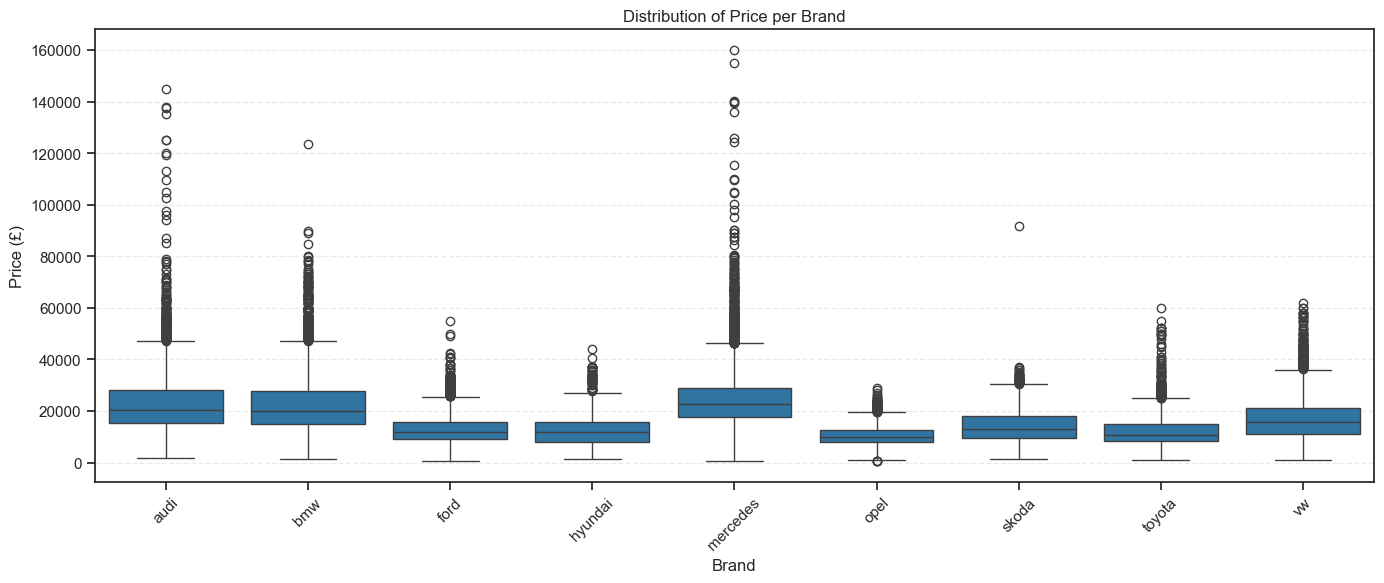

In [58]:
plt.figure(figsize=(14,6))
# Build DataFrame from brand y_train Series (Series -> DataFrame with column 'price')
df_prices = pd.concat(
    [pd.DataFrame({'price': brand_preprocessed[b]['y_train']}).assign(Brand=b) for b in brands],
    axis=0
).reset_index(drop=True)

# Convert from log-price back to original price scale
import numpy as np
df_prices['price'] = np.exp(df_prices['price'])

sns.boxplot(data=df_prices, x='Brand', y='price')
plt.title("Distribution of Price per Brand")
plt.ylabel('Price (£)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Grid Search and Tuning

In [59]:
# Storage for all brand results
brand_knn_results = {}

# Define your search range (based on global analysis at Modeling phase)
param_grid = {'n_neighbors': list(range(7, 101))}

for brand in brands:
    print(f" Running KNN Grid Search for → {brand}")

    # Load ORIGINAL raw data for this brand (not the preprocessed version)
    mask = (X_M['Brand'] == brand)
    X_brand_raw = X_M.loc[mask].reset_index(drop=True).copy()
    y_brand_raw = y_M.loc[mask].reset_index(drop=True).copy()
    
    # Drop Brand column for modeling
    X_brand_raw = X_brand_raw.drop(columns=['Brand'])

    # Train/test split on raw data
    from sklearn.model_selection import train_test_split
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_brand_raw, y_brand_raw, test_size=0.20, random_state=42
    )

    # Dictionaries to store scores
    dic_train = {}
    dic_val = {}

    # Grid Search on preprocessed data
    # -----------------------------------------------------------------------
    # For grid search, we use the preprocessed train/test sets
    X_train = brand_preprocessed[brand]['X_train'].drop(columns=['Brand'])
    X_test  = brand_preprocessed[brand]['X_test'].drop(columns=['Brand'])

    for params in tqdm(ParameterGrid(param_grid)):
        k = params['n_neighbors']

        model = KNeighborsRegressor(
            n_neighbors=k,
            weights='uniform',
            n_jobs=-1
        )

        # Use your scoring function
        grid_score(
            x_train = X_train,
            y_train = y_train,
            x_val   = X_test,
            y_val   = y_test,
            model   = model,
            score_train_dic = dic_train,
            score_val_dic   = dic_val,
            dic_key = ('KNN', k),
            log_transform = True
        )

    # Find best k (lowest validation MAE)
    best_k = min(dic_val, key=dic_val.get)[1]
    best_val_mae = dic_val[('KNN', best_k)]
    best_train_mae = dic_train[('KNN', best_k)]
    overfit_gap = best_val_mae - best_train_mae

    print(f"Best k for {brand}: {best_k}")
    print(f"Validation MAE: {best_val_mae:.2f}")
    print(f"Overfitting gap: {overfit_gap:.2f}")

    # Cross-Validation
    # -----------------------------------------------------------------------

    # CV scoring dictionaries (for consistency)
    dic_train_cv = {}
    dic_val_cv = {}

    # Create KFold object for cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Use the raw data for CV since avg_scores() expects to do preprocessing
    avg_scores(
        X = X_train_raw,
        y = y_train,
        CV = kfold,
        imputer = brand_preprocessed[brand]['imputer'],
        scalar = brand_preprocessed[brand]['scaler'],
        model = KNeighborsRegressor(n_neighbors=best_k, weights='uniform', n_jobs=-1),
        score_train_dic = dic_train_cv,
        score_val_dic   = dic_val_cv,
        dic_key = f'KNN_{brand}',
        log_transform = True
    )

    print_cv_results(f'KNN_{brand}', dic_train_cv, dic_val_cv)

    # Store all results
    brand_knn_results[brand] = {
        'best_k': best_k,
        'train_MAE': best_train_mae,
        'val_MAE': best_val_mae,
        'overfitting_gap': overfit_gap,
        'cv_train_mae': dic_train_cv[f'KNN_{brand}'][0],
        'cv_val_mae': dic_val_cv[f'KNN_{brand}'][0],
        'encoder': brand_preprocessed[brand]['encoder'],
        'scaler': brand_preprocessed[brand]['scaler'],
        'imputer': brand_preprocessed[brand]['imputer']
    }

 Running KNN Grid Search for → audi


100%|██████████| 94/94 [00:11<00:00,  7.89it/s]


Best k for audi: 7
Validation MAE: 2350.76
Overfitting gap: 367.07


5it [00:01,  4.93it/s]



CV Results - KNN_audi
Train MAE: 2032.08, Train std: 14.63
Validation MAE: 2356.99, Validatin std: 26.26
 Running KNN Grid Search for → bmw


100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Best k for bmw: 8
Validation MAE: 2734.78
Overfitting gap: 386.09


5it [00:00,  5.38it/s]
5it [00:00,  5.38it/s]


CV Results - KNN_bmw
Train MAE: 2397.33, Train std: 15.13
Validation MAE: 2762.04, Validatin std: 44.12
 Running KNN Grid Search for → ford


100%|██████████| 94/94 [00:21<00:00,  4.34it/s]


Best k for ford: 9
Validation MAE: 1074.48
Overfitting gap: 81.80


5it [00:12,  2.53s/it]



CV Results - KNN_ford
Train MAE: 1012.23, Train std: 4.39
Validation MAE: 1138.81, Validatin std: 9.84
 Running KNN Grid Search for → hyundai


100%|██████████| 94/94 [00:05<00:00, 17.13it/s]


Best k for hyundai: 7
Validation MAE: 1152.82
Overfitting gap: 174.27


5it [00:00, 12.79it/s]



CV Results - KNN_hyundai
Train MAE: 1007.14, Train std: 9.52
Validation MAE: 1170.2, Validatin std: 50.27
 Running KNN Grid Search for → mercedes


100%|██████████| 94/94 [00:16<00:00,  5.85it/s]


Best k for mercedes: 7
Validation MAE: 2544.29
Overfitting gap: 332.82


5it [00:05,  1.15s/it]



CV Results - KNN_mercedes
Train MAE: 2270.16, Train std: 16.35
Validation MAE: 2645.18, Validatin std: 96.25
 Running KNN Grid Search for → opel


100%|██████████| 94/94 [00:12<00:00,  7.58it/s]


Best k for opel: 9
Validation MAE: 934.23
Overfitting gap: 85.25


5it [00:01,  3.51it/s]



CV Results - KNN_opel
Train MAE: 863.96, Train std: 5.62
Validation MAE: 966.65, Validatin std: 42.0
 Running KNN Grid Search for → skoda


100%|██████████| 94/94 [00:07<00:00, 13.12it/s]


Best k for skoda: 8
Validation MAE: 1457.87
Overfitting gap: 188.23


5it [00:00, 10.62it/s]



CV Results - KNN_skoda
Train MAE: 1302.72, Train std: 20.62
Validation MAE: 1491.58, Validatin std: 66.79
 Running KNN Grid Search for → toyota


100%|██████████| 94/94 [00:05<00:00, 16.55it/s]


Best k for toyota: 7
Validation MAE: 1170.23
Overfitting gap: 212.75


5it [00:00, 10.80it/s]



CV Results - KNN_toyota
Train MAE: 992.73, Train std: 8.38
Validation MAE: 1176.47, Validatin std: 40.35
 Running KNN Grid Search for → vw


100%|██████████| 94/94 [00:14<00:00,  6.46it/s]


Best k for vw: 7
Validation MAE: 1689.99
Overfitting gap: 250.73


5it [00:01,  3.76it/s]

CV Results - KNN_vw
Train MAE: 1480.27, Train std: 13.3
Validation MAE: 1746.64, Validatin std: 67.65


Data representation and comparison with our KNN model for all the brands all together

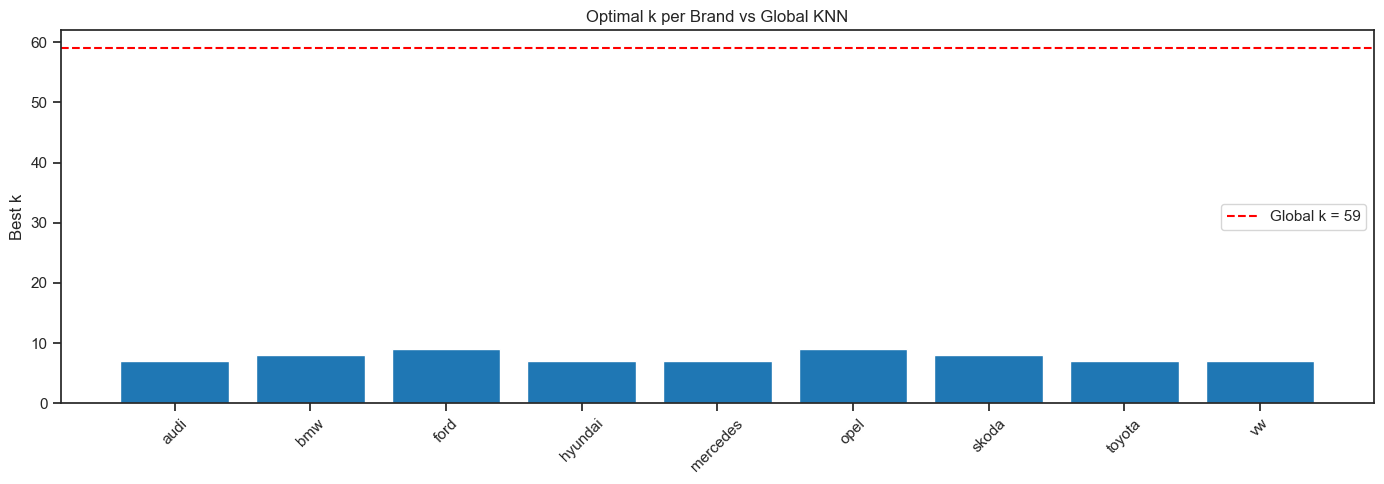

In [60]:
global_k = 59 # From modeling the whole data not dividing by brands global k value
global_val_mae = 2458.21 # From global modeling
global_cv_val_mae = 2503.57  # From global modeling
import pandas as pd

comparison_rows = []

for brand, res in brand_knn_results.items():
    comparison_rows.append({
        'Brand': brand,
        'Best k (Brand)': res['best_k'],
        'Val MAE (Brand)': res['val_MAE'],
        'Train MAE (Brand)': res['train_MAE'],
        'Overfit Gap (Brand)': res['overfitting_gap'],
        'CV Val MAE (Brand)': res['cv_val_mae'],
        'CV Train MAE (Brand)': res['cv_train_mae'],
        # comparison to global
        'Global k': global_k,
        'Global Val MAE': global_val_mae,
        'Global CV Val MAE': global_cv_val_mae
    })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df = comparison_df.sort_values('Val MAE (Brand)').reset_index(drop=True)

comparison_df

# Bar plot: show optimal k per brand
brands_list = [b for b in brand_knn_results.keys()]
k_values = [res['best_k'] for res in brand_knn_results.values()]

plt.figure(figsize=(14,5))
plt.bar(brands_list, k_values, color='tab:blue')
plt.axhline(global_k, color='red', linestyle='--', label=f'Global k = {global_k}')
plt.title("Optimal k per Brand vs Global KNN")
plt.ylabel("Best k")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


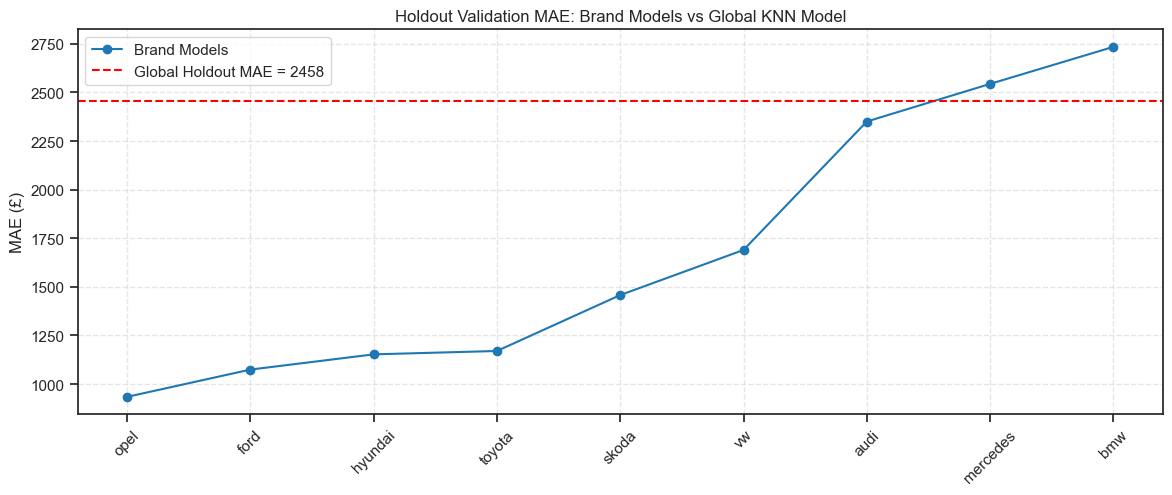

In [61]:
plt.figure(figsize=(14,5))
plt.plot(comparison_df['Brand'], comparison_df['Val MAE (Brand)'], marker='o', label='Brand Models')
plt.axhline(global_val_mae, color='red', linestyle='--', label=f'Global Holdout MAE = {global_val_mae:.0f}')

plt.title("Holdout Validation MAE: Brand Models vs Global KNN Model")
plt.ylabel("MAE (£)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


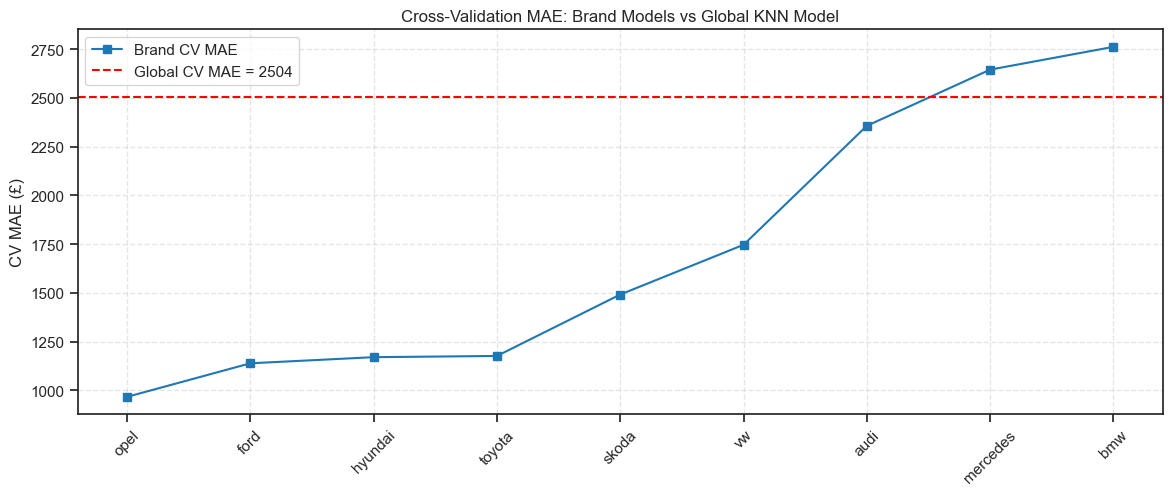

In [62]:

plt.figure(figsize=(14,5))
plt.plot(comparison_df['Brand'], comparison_df['CV Val MAE (Brand)'], marker='s', label='Brand CV MAE')
plt.axhline(global_cv_val_mae, color='red', linestyle='--', label=f'Global CV MAE = {global_cv_val_mae:.0f}')

plt.title("Cross-Validation MAE: Brand Models vs Global KNN Model")
plt.ylabel("CV MAE (£)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


 Build final models for each brand using best k found

In [63]:
print(X_brand_full.isnull().sum())

Brand             0
transmission    288
mileage         194
mpg             204
engineSize      188
Years_old         0
dtype: int64


In [64]:
# Build final models for each brand using best k found
brand_final_models = {}

for brand in brands:
    best_k = brand_knn_results[brand]['best_k']

    model = KNeighborsRegressor(
        n_neighbors=best_k,
        weights='uniform',
        n_jobs=-1
    )
    
    # Create FRESH preprocessing objects (not reusing pre-fitted ones)
    # Handle transmission categorical imputation first
    transmission_mode_new = None
    
    # Get raw data for this brand
    mask = X_M['Brand'] == brand
    X_brand_full = X_M.loc[mask].drop(columns=['Brand']).copy()
    y_brand_full = y_M.loc[mask].copy()
    
    # Fill transmission mode
    if 'transmission' in X_brand_full.columns:
        transmission_mode_new = X_brand_full['transmission'].mode()[0]
        X_brand_full['transmission'] = X_brand_full['transmission'].fillna(transmission_mode_new)
    
    # Define OneHotEncoder for transmission
    ohe = OneHotEncoder(
        categories=[['automatic', 'manual', 'semi-auto']],
        drop=['automatic'],
        handle_unknown='ignore',
        sparse_output=False,
        dtype=int
    )
    
    # Define ColumnTransformer for encoding
    preproc = ColumnTransformer(
        transformers=[
            ('enc_trans', ohe, ['transmission'])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    preproc.set_output(transform='pandas')
    
    # Create fresh scaler and imputer
    scaler = RobustScaler()
    imputer = KNNImputer(n_neighbors=10, weights='uniform')
    
    # Build final pipeline for this brand
    pipe = Pipeline(steps=[
        ('encoder', preproc),
        ('scaler', scaler),
        ('imputer', imputer),
        ('model', model)
    ])

    # Fit using the FULL raw brand dataset
    pipe.fit(X_brand_full, y_brand_full)

    # Store pipeline
    brand_final_models[brand] = pipe

print("Final models built for all brands!")


Final models built for all brands!


In [65]:
def predict_all_brands(df, brand_models):
    df = df.copy()

    all_predictions = []

    for brand, model in brand_models.items():

        brand_mask = df['Brand'] == brand
        df_brand = df.loc[brand_mask].copy()

        if df_brand.empty:
            continue

        X_input = df_brand.drop(columns=['Brand'])
        
        preds = model.predict(X_input)
        
        df_brand['PredictedPrice'] = preds
        
        all_predictions.append(df_brand)

    final_df = pd.concat(all_predictions).sort_index()
    return final_df


In [67]:
# Load test data
test_data = pd.read_csv('../project_data/test.csv')

# Make predictions on test data
# predicted_df = predict_all_brands(test_data, brand_final_models)

# Display predictions
predicted_df.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,PredictedPrice
0,76189,audi,tt,2017.0,manual,30562.000000,diesel,145.0,62.8,2.0,NaN,1.0,0.0,17532.479751
0,85391,ford,fiesta,2018.0,manual,29626.000000,petrol,145.0,65.7,1.0,64.0,1.0,0.0,10702.182325
0,98302,toyota,aygo,2017.0,manual,13255.000000,petrol,145.0,69.0,1.0,35.0,3.0,0.0,7699.654769
0,96210,skoda,superb,2019.0,manual,20632.000000,diesel,145.0,64.2,2.0,99.0,3.0,0.0,16550.975403
0,106581,vw,tiguan,2017.0,semi-auto,-48190.655673,petrol,150.0,38.2,2.0,60.0,2.0,0.0,21504.233498


Here we are doing the same preprocessing as we did in "Cars4you_EDA_Preprocesing.ipynb"

In [68]:
def preprocess_full_dataset(df_raw,
                            dict_brand_mapping,
                            dict_transmission_mapping,
                            mode_transmission,
                            encoder,
                            scaler,
                            imputer):
    """
    This function reproduces EXACTLY your final preprocessing pipeline.
    - fix text
    - apply brand/transmission mapping
    - clean numerics
    - remove unwanted columns
    - feature engineering
    - mode imputation for transmission
    - OHE encoding (using saved encoder)
    - scaling (using saved scaler)
    - KNN imputation (using saved imputer)
    """
    df = df_raw.copy()

    # CLEAN TEXT INCONSISTENCIES
    # -------------------------------------------
    df = df.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)

    # brand mapping
    for key, values in dict_brand_mapping.items():
        df.loc[df['Brand'].isin(values), 'Brand'] = key

    # transmission mapping
    for key, values in dict_transmission_mapping.items():
        df.loc[df['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan

    # REMOVE UNWANTED COLUMNS
    # -------------------------------------------
    drop_cols = ['model', 'tax', 'previousOwners', 'fuelType',
                 'paintQuality%', 'hasDamage']
    
    df = df.drop(columns=drop_cols, errors='ignore')

    # FIX NUMERIC COLUMNS
    # -------------------------------------------
    numeric_cols = ['mileage','mpg','engineSize']

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').abs()

    df.loc[df['engineSize'] < 0.9, 'engineSize'] = 0.9
    df['year'] = df['year'].round().astype("Int64")
    df = df[df['year'] <= 2020]

    # FEATURE ENGINEERING
    # -------------------------------------------
    df['Years_old'] = 2021 - df['year']
    df = df.drop(columns=['year'])

    # MODE IMPUTATION (transmission)
    # -------------------------------------------
    df['transmission'].fillna(mode_transmission, inplace=True)

    # SAVE BRAND COLUMN FOR LATER
    # -------------------------------------------
    brands = df['Brand']
    df = df.drop(columns=['Brand'])

    # APPLY ENCODER (OHE)
    # -------------------------------------------
    df_encoded = encoder.transform(df)

    # SCALE
    # -------------------------------------------
    df_scaled = scaler.transform(df_encoded)

    # KNN IMPUTE
    # -------------------------------------------
    df_imputed = imputer.transform(df_scaled)

    # REBUILD DF
    # -------------------------------------------
    df_final = pd.DataFrame(df_imputed, columns=df_encoded.columns)
    df_final['Brand'] = brands.values

    return df_final


In [70]:
#df_train_raw = pd.read_csv('../project_data/train.csv')

#X_processed = preprocess_full_dataset(
#    df_raw=df_train_raw,
#    dict_brand_mapping=dict_brand_mapping,
#    dict_transmission_mapping=dict_transmission_mapping,
#    mode_transmission=mode_transmission_full,
#    encoder=encoder_full,
#    scaler=scaler_full,
#    imputer=inputer_full
#)

#y_processed = np.log(df_train_raw['price'])
#X_processed.head()


In [71]:
#df_test_raw = pd.read_csv('../project_data/test.csv')
#
#X_test_processed = preprocess_full_dataset(
#   df_raw=df_test_raw,
#    dict_brand_mapping=dict_brand_mapping,
#    dict_transmission_mapping=dict_transmission_mapping,
#    mode_transmission=mode_transmission_full,
#    encoder=encoder_full,
#    scaler=scaler_full,
#    imputer=inputer_full
#)

#preds = model.predict(X_test_processed.drop(columns=['Brand']))
#preds_original_scale = np.exp(preds)


# KNN 2.0

## Project Setup

### File Paths and Data Configuration

In this section, we define the file paths for our project data and serialized objects:

- `DATA_DIR`: The main directory where all project data files are stored.
- `PICKLE_MODEL_OPT`: Path to the pickled file containing the optimized model dataset `(X_M, y_M)` used for model optimization.
- `PICKLE_DICTS`: Path to the pickled file containing dictionaries `(dict_brand_mapping, dict_transmission_mapping)` for categorical mappings like car brands and transmission types.
- `PICKLE_FULL`: Path to the pickled file containing the full modeling dataset `(X_full, y_Modeling)`, along with preprocessing objects such as the scaler, mode for transmission, and imputer.
- `TEST_CSV`: Path to the CSV file containing test data for predictions or evaluation.

These paths allow us to easily load and manage datasets and preprocessed objects throughout the project.


In [72]:
DATA_DIR = '../project_data'
PICKLE_MODEL_OPT = os.path.join(DATA_DIR, 'X_Ylog_ModelOptimization.pkl')   # (X_M, y_M)
PICKLE_DICTS = os.path.join(DATA_DIR, 'DicBrand_DicTrans_PrePro.pkl')       # (dict_brand_mapping, dict_transmission_mapping)
PICKLE_FULL = os.path.join(DATA_DIR, 'X_Ylog_Scale_Impute_ModelFull.pkl')   # (X_full, y_Modeling, scaler, mode_transmission_full, inputer)

TEST_CSV = os.path.join(DATA_DIR, 'test.csv')

### Utility Function: MAE on Original Scale

`mae_original_scale` computes the **Mean Absolute Error (MAE)** for log-transformed predictions by first converting them back to the original scale.  

- **Inputs**: `y_true_log` and `y_pred_log` (log-transformed values)  
- **Output**: MAE in the original units (e.g., prices)  

Useful when the model is trained on log-transformed targets but evaluation is needed in the original scale.

In [73]:
# Utilities
def mae_original_scale(y_true_log, y_pred_log):
    """Compute MAE on original price scale (y are natural-log)."""
    return mean_absolute_error(np.exp(y_true_log), np.exp(y_pred_log))


### Loading Preprocessed Data and Setting Parameters



- **Load pickled datasets**:
  - `X_M`: Cleaned features with brands present.
  - `y_M`: Log-transformed target variable (price).  
  Both are reset to ensure clean, consecutive indexing.

- **Load mapping dictionaries**:
  - `dict_brand_mapping` and `dict_transmission_mapping` for categorical encoding.

- **Extract unique brands** from `X_M` for later use.

- **Define parameter grid** for model tuning:
  - `n_neighbors` will be tested in the range 7 to 100 (used in KNN-based models).


In [74]:
X_M, y_M = pd.read_pickle(PICKLE_MODEL_OPT)   # X_M: cleaned (brand present), y_M: log(price)
X_M = X_M.reset_index(drop=True)
y_M = y_M.reset_index(drop=True)

dict_brand_mapping, dict_transmission_mapping = pd.read_pickle(PICKLE_DICTS)


brands = np.sort(X_M['Brand'].unique())

param_grid = {'n_neighbors': list(range(7, 101))}

### Data representation:

Sample count per brand (top 20):


,Brand,Samples
0,ford,15673
1,mercedes,11382
2,vw,10121
3,opel,9134
4,bmw,7214
5,audi,7147
6,toyota,4519
7,skoda,4194
8,hyundai,3261


Total samples: 72,645 across 9 brands



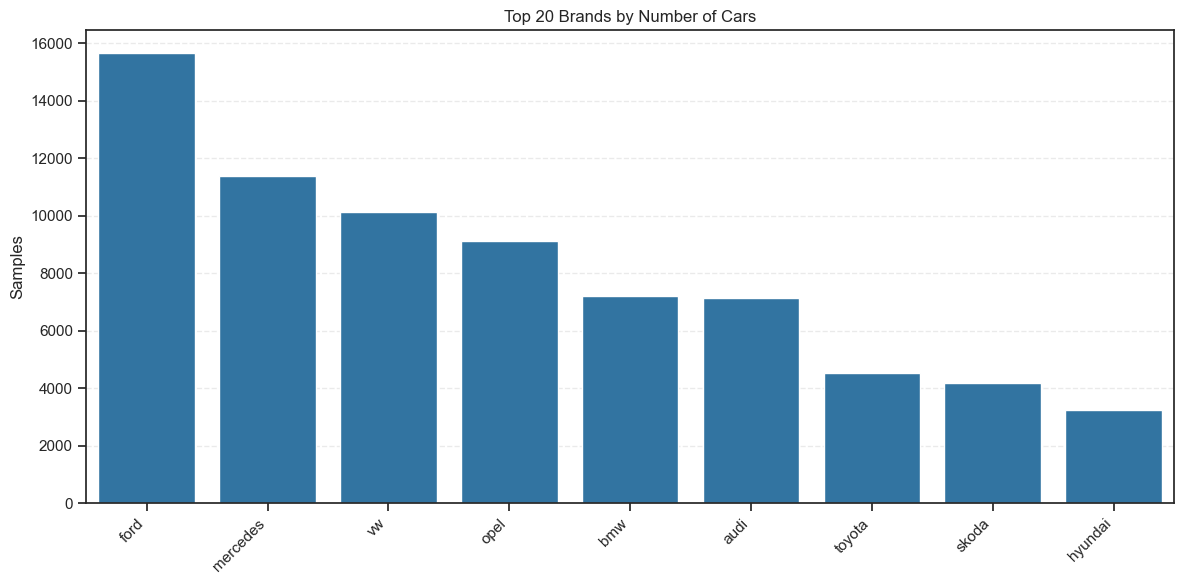

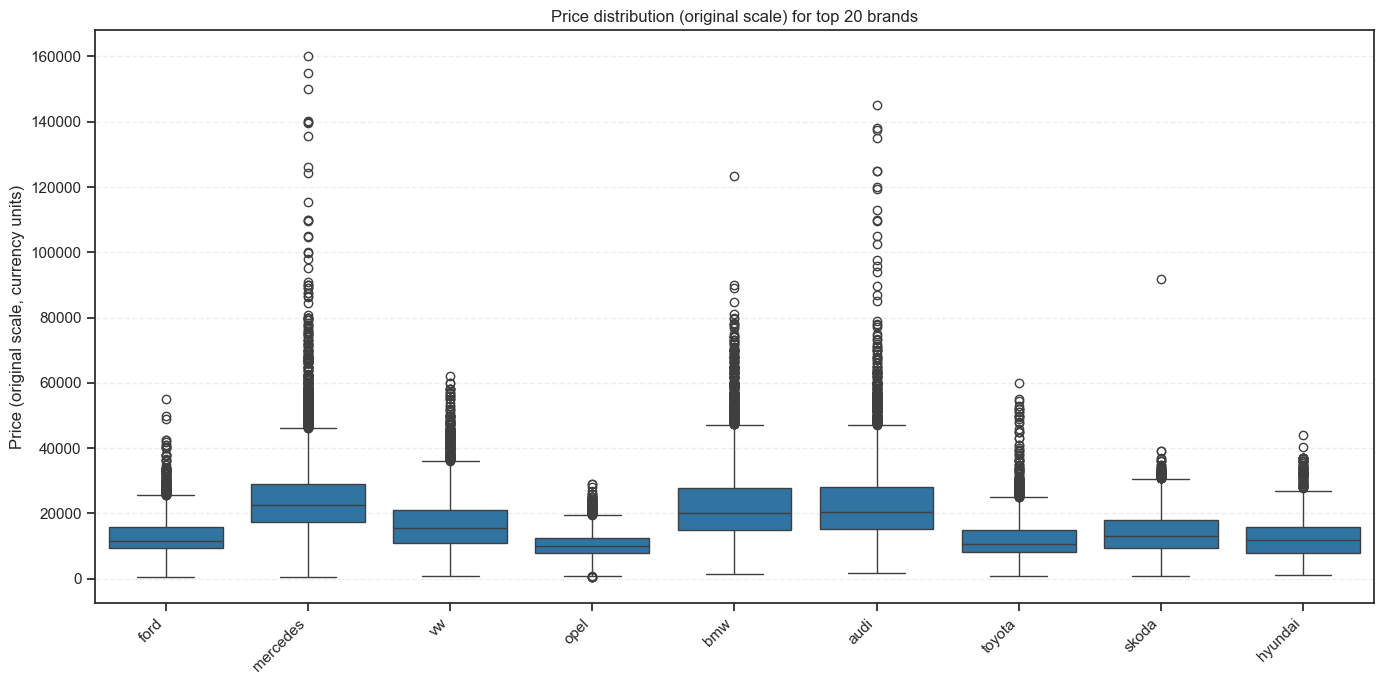


Price summary (top 10 brands):


,Brand,Samples,median,mean,std,min,max
0,ford,15673,11700.0,12568.341032,4781.813903,495.0,54995.0
1,mercedes,11382,22643.0,24483.775962,11196.345094,650.0,159999.0
2,vw,10121,15681.0,16881.446596,7724.411424,899.0,61995.0
3,opel,9134,9999.0,10363.705715,3564.477110,450.0,28995.0
4,bmw,7214,20206.5,22677.380233,11446.143319,1500.0,123456.0
5,audi,7147,20430.0,22902.093046,11645.120494,1699.0,145000.0
6,toyota,4519,10698.0,12487.068157,6354.555352,850.0,59995.0
7,skoda,4194,12999.0,14217.456605,6226.987507,995.0,91874.0
8,hyundai,3261,11998.0,12789.739957,5932.689128,1200.0,43995.0


In [ ]:
# --- Build brand_sizes in a robust way ---
if 'brand_preprocessed' in globals() and isinstance(brand_preprocessed, dict) and len(brand_preprocessed) > 0:
    # Preferred: use brand_preprocessed counts (train + test sizes)
    brand_sizes = {}
    for brand, content in brand_preprocessed.items():
        try:
            n_train = int(getattr(content.get('X_train'), "shape", (0,))[0]) if isinstance(content.get('X_train'), (pd.DataFrame, np.ndarray)) else 0
            n_test = int(getattr(content.get('X_test'), "shape", (0,))[0]) if isinstance(content.get('X_test'), (pd.DataFrame, np.ndarray)) else 0
        except Exception:
            n_train = n_test = 0
        brand_sizes[brand] = n_train + n_test

else:
    # Fallback: compute counts from X_M Brand column
    if 'X_M' in globals() and 'Brand' in X_M.columns:
        brand_sizes = X_M['Brand'].value_counts().to_dict()
    else:
        raise RuntimeError("Cannot build brand size summary: neither `brand_preprocessed` nor `X_M` with 'Brand' exists.")

# Create DataFrame and sort
brand_sizes_df = (
    pd.DataFrame.from_dict(brand_sizes, orient='index', columns=['Samples'])
      .rename_axis('Brand')
      .reset_index()
      .sort_values('Samples', ascending=False)
      .reset_index(drop=True)
)

# Display summary table (top 20 + overall stats)
print("Sample count per brand (top 20):")
display(brand_sizes_df.head(20))

total_samples = brand_sizes_df['Samples'].sum()
n_brands = brand_sizes_df.shape[0]
print(f"Total samples: {total_samples:,} across {n_brands} brands\n")

# --- Bar plot: number of cars per brand (top 20 for readability) ---
top_n = 20
plot_df = brand_sizes_df.head(top_n).copy()

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Brand', y='Samples', order=plot_df['Brand'])
plt.title(f"Top {top_n} Brands by Number of Cars")
plt.xlabel("")
plt.ylabel("Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Price distribution per brand (boxplot) ---
# We prefer to use per-brand y_train samples from brand_preprocessed (if available)
price_rows = []
if 'brand_preprocessed' in globals() and isinstance(brand_preprocessed, dict) and len(brand_preprocessed) > 0:
    for b, content in brand_preprocessed.items():
        # Attempt to extract y_train (which should be log-price); if missing, try y_test or skip
        y_train_series = content.get('y_train') or content.get('y') or content.get('y_full') or content.get('y_test')
        if y_train_series is None:
            continue
        # Convert to pandas Series if needed
        y_train_series = pd.Series(y_train_series).reset_index(drop=True)
        # Convert back to original price scale if it is in log
        # Heuristic: if median is < 30 it's likely log-prices; if > 1000 it's likely original prices
        median_val = float(np.nanmedian(y_train_series.dropna()))
        if median_val < 30:
            prices = np.exp(y_train_series)
        else:
            prices = y_train_series
        tmp = pd.DataFrame({'Brand': b, 'price': prices})
        price_rows.append(tmp)
# Fallback: use X_M & y_M to build price samples
if len(price_rows) == 0 and ('X_M' in globals() and 'y_M' in globals()):
    df_temp = X_M[['Brand']].copy().reset_index(drop=True)
    df_temp['price_log'] = y_M.reset_index(drop=True)
    df_temp['price'] = np.exp(df_temp['price_log'])
    price_rows = [df_temp[['Brand', 'price']]]

if len(price_rows) == 0:
    print("No price data available to plot price distributions per brand.")
else:
    df_prices = pd.concat(price_rows, axis=0).reset_index(drop=True)
    # Keep only top N brands for legibility
    top_brands = brand_sizes_df.head(top_n)['Brand'].values
    df_prices_top = df_prices[df_prices['Brand'].isin(top_brands)].copy()

    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_prices_top, x='Brand', y='price', order=top_brands)
    plt.title(f"Price distribution (original scale) for top {top_n} brands")
    plt.ylabel("Price (original scale, currency units)")
    plt.xlabel("")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.35)
    plt.tight_layout()
    plt.show()

# --- Additional summary statistics per brand (optional, top 10) ---
summary_stats = (
    df_prices.groupby('Brand')['price']
             .agg(['count','median','mean','std','min','max'])
             .rename(columns={'count':'Samples'})
             .loc[brand_sizes_df['Brand'].values]  # preserve ordering
             .reset_index()
)
print("\nPrice summary (top 10 brands):")
display(summary_stats.head(10))


## Sub Processes/Functions for Preprocessing, Grid Search and CV

### Function: Preprocess Full Dataset


`preprocess_full_dataset` reproduces the **final preprocessing pipeline** applied during modeling, ensuring new data matches the format used for training.  

- **Inputs**:
  - `df_raw`: Raw input DataFrame.  
  - `dict_brand_mapping`, `dict_transmission_mapping`: Dictionaries for categorical normalization.  
  - `mode_transmission`: Most frequent transmission type for filling missing values.  
  - `encoder`, `scaler`, `imputer`: Fitted preprocessing objects from training.  

- **Process**:
  1. Clean text inconsistencies and normalize strings.  
  2. Map brands and transmission types to consistent categories.  
  3. Remove unwanted columns.  
  4. Fix numeric columns (convert, take absolute values, clip/round as needed).  
  5. Feature engineering: create `Years_old` from `year`.  
  6. Fill missing `transmission` values using `mode_transmission`.  
  7. Apply saved **OHE encoder**, **scaler**, and **KNN imputer**.  
  8. Reattach the `'Brand'` column.  

- **Output**:
  - Fully preprocessed DataFrame ready for brand-specific modeling.


In [75]:
def preprocess_full_dataset(df_raw,
                            dict_brand_mapping,
                            dict_transmission_mapping,
                            mode_transmission,
                            encoder,
                            scaler,
                            imputer):
    """
    This function reproduces EXACTLY your final preprocessing pipeline.
    - fix text
    - apply brand/transmission mapping
    - clean numerics
    - remove unwanted columns
    - feature engineering
    - mode imputation for transmission
    - OHE encoding (using saved encoder)
    - scaling (using saved scaler)
    - KNN imputation (using saved imputer)
    """
    df = df_raw.copy()

    # CLEAN TEXT INCONSISTENCIES
    # -------------------------------------------
    df = df.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)

    # brand mapping
    for key, values in dict_brand_mapping.items():
        df.loc[df['Brand'].isin(values), 'Brand'] = key

    # transmission mapping
    for key, values in dict_transmission_mapping.items():
        df.loc[df['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan

    # REMOVE UNWANTED COLUMNS
    # -------------------------------------------
    drop_cols = ['model', 'tax', 'previousOwners', 'fuelType',
                 'paintQuality%', 'hasDamage']
    
    df = df.drop(columns=drop_cols, errors='ignore')

    # FIX NUMERIC COLUMNS
    # -------------------------------------------
    numeric_cols = ['mileage','mpg','engineSize']

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').abs()
    
    df.loc[df['engineSize'] < 0.9, 'engineSize'] = 0.9
    df['year'] = df['year'].round().astype("Int64")
    df['year'] = df['year'].clip(upper=2020)

    # FEATURE ENGINEERING
    # -------------------------------------------
    df['Years_old'] = 2021 - df['year']
    df = df.drop(columns=['year'])

    # MODE IMPUTATION (transmission)
    # -------------------------------------------
    df['transmission'].fillna(mode_transmission, inplace=True)

    # SAVE BRAND COLUMN FOR LATER
    # -------------------------------------------
    brands = df['Brand']
    df = df.drop(columns=['Brand'])

    # APPLY ENCODER (OHE)
    # -------------------------------------------
    df_encoded = encoder.transform(df)

    # SCALE
    # -------------------------------------------
    df_scaled = scaler.transform(df_encoded)

    # KNN IMPUTE
    # -------------------------------------------
    df_imputed = imputer.transform(df_scaled)

    # REBUILD DF
    # -------------------------------------------
    df_final = pd.DataFrame(df_imputed, columns=df_encoded.columns)
    df_final['Brand'] = brands.values

    return df_final


### Function: Build and Fit Preprocessor

`build_and_fit_preprocessor` prepares the training features for modeling by applying **encoding, scaling, and imputation**.  

- **Inputs**:
  - `X_train_no_brand`: Training features without the 'Brand' column.
  - `transmission_mode` (optional): Most frequent transmission value used to fill missing entries.  

- **Process**:
  1. Fill missing `transmission` values if a mode is provided.
  2. One-Hot Encode the `transmission` column (dropping `'automatic'`).
  3. Scale all features using `RobustScaler`.
  4. Impute any remaining missing values with `KNNImputer`.

- **Outputs**:
  - `preproc`: Fitted column transformer for encoding.
  - `scaler`: Fitted scaler.
  - `imputer`: Fitted imputer.
  - `X_train_final`: Fully preprocessed training DataFrame ready for modeling.


In [76]:
def build_and_fit_preprocessor(X_train_no_brand, transmission_mode=None):
    """
    Fit encoder (OHE on 'transmission'), scaler (RobustScaler) and imputer (KNNImputer)
    Return fitted (preproc, scaler, imputer) and transformed train DataFrame.
    NOTE: X_train_no_brand should NOT include 'Brand'.
    """
    X_train = X_train_no_brand.copy()

    # Only fill transmission when there are missing values AND a mode was provided
    if 'transmission' in X_train.columns and transmission_mode is not None:
        if X_train['transmission'].isna().any():
            X_train['transmission'] = X_train['transmission'].fillna(transmission_mode)

    ohe = OneHotEncoder(
        categories=[['automatic', 'manual', 'semi-auto']],
        drop=['automatic'],
        handle_unknown='ignore',
        sparse_output=False,
        dtype=int
    )

    preproc = ColumnTransformer(
        transformers=[('enc_trans', ohe, ['transmission'])],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    preproc.set_output(transform='pandas')

    # Fit encoder on X_train (pandas output)
    X_train_enc = preproc.fit_transform(X_train)

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_enc)

    imputer = KNNImputer(n_neighbors=10, weights='uniform')
    X_train_imputed = imputer.fit_transform(X_train_scaled)

    X_train_final = pd.DataFrame(X_train_imputed, columns=X_train_enc.columns, index=X_train.index)
    return preproc, scaler, imputer, X_train_final


### Function: Transform Features with Preprocessing Pipeline



`transform_with_preproc` applies a previously fitted preprocessing pipeline to new data.  

- **Inputs**:
  - `preproc`: Fitted encoder (e.g., One-Hot Encoder for `transmission`).  
  - `scaler`: Fitted scaler (e.g., `RobustScaler`).  
  - `imputer`: Fitted imputer (e.g., `KNNImputer`).  
  - `X_raw_with_brand`: Raw DataFrame including the `'Brand'` column.  

- **Process**:
  1. Separate `'Brand'` column from other features.  
  2. Apply encoding, scaling, and imputation to the remaining features.  
  3. Reattach the `'Brand'` column to the transformed data.  

- **Output**:
  - Fully preprocessed DataFrame with all features ready for modeling.

In [77]:
def transform_with_preproc(preproc, scaler, imputer, X_raw_with_brand):
    df = X_raw_with_brand.reset_index(drop=True).copy()
    
    brands_col = df['Brand'].values
    df_no_brand = df.drop(columns=['Brand'])

    df_enc = preproc.transform(df_no_brand)
    df_scaled = scaler.transform(df_enc)
    df_imp = imputer.transform(df_scaled)

    df_out = pd.DataFrame(df_imp, columns=df_enc.columns)
    df_out['Brand'] = brands_col

    return df_out



### Function: Prepare Brand-Specific Data


`prepare_brand_data` extracts data for a specific brand and creates a local **80/20 train-validation split**.  

- **Inputs**:
  - `X_M`, `y_M`: Full feature and target datasets.  
  - `brand`: Brand name to filter the data.  

- **Process**:
  1. Filter rows corresponding to the selected brand.  
  2. Drop the `'Brand'` column for modeling.  
  3. Split the brand-specific data into training (80%) and validation (20%) sets.  

- **Outputs**:
  - `X_train_raw`, `X_val_raw`, `y_train`, `y_val`: Local split datasets for modeling.  
  - `X_b_full`, `y_b_full`: Full brand-specific data (kept for reference or evaluation).


In [78]:
def prepare_brand_data(X_M, y_M, brand):
    """Extract brand rows and make a local 80/20 split."""
    mask = (X_M['Brand'] == brand)
    X_b_full = X_M.loc[mask].reset_index(drop=True).copy()
    y_b_full = y_M.loc[mask].reset_index(drop=True).copy()

    # Drop brand before splitting
    X_b_raw = X_b_full.drop(columns=['Brand']).copy()
    y_b = y_b_full.copy()

    # Local hold-out split
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        X_b_raw, y_b, test_size=0.20, random_state=42
    )

    return X_train_raw, X_val_raw, y_train, y_val, X_b_full, y_b_full

### Function: Fit Brand-Specific Preprocessing



`fit_brand_preprocessing` fits the preprocessing pipeline **using only the training data** for a specific brand.  

- **Inputs**:
  - `X_train_raw`: Brand-specific training features (without splitting the full dataset).  

- **Process**:
  1. Sanitize `transmission` column by replacing unexpected values with `NaN`.  
  2. Determine the most frequent `transmission` value (`transmission_mode`) from the training set and fill missing values.  
  3. Fit encoder, scaler, and imputer using `build_and_fit_preprocessor`.  

- **Outputs**:
  - `preproc`, `scaler`, `imputer`: Fitted preprocessing objects.  
  - `transmission_mode`: Most frequent transmission value used for imputation.  
  - `X_train_final`: Fully preprocessed training DataFrame ready for modeling.

In [79]:
def fit_brand_preprocessing(X_train_raw):
    """Fit encoder, scaler, imputer on TRAIN data only and return fitted objects + transmission_mode."""
    
    X_train_raw = X_train_raw.copy()

    # Determine transmission_mode only from the TRAIN partition
    if 'transmission' in X_train_raw.columns:
        # NEW: sanitize unexpected values
        allowed_trans = ['automatic', 'manual', 'semi-auto']
        X_train_raw.loc[~X_train_raw['transmission'].isin(allowed_trans), 'transmission'] = np.nan

        transmission_mode = X_train_raw['transmission'].mode().iloc[0]
    
        # fill missing only
        if X_train_raw['transmission'].isna().any():
            X_train_raw['transmission'] = X_train_raw['transmission'].fillna(transmission_mode)

    else:
        transmission_mode = None

    preproc, scaler, imputer, X_train_final = build_and_fit_preprocessor(
        X_train_raw, transmission_mode
    )

    return preproc, scaler, imputer, transmission_mode, X_train_final


### Function: Transform Brand Data




`transform_brand_data` applies the preprocessing pipeline to **any subset of a specific brand** (train, validation, full, or test).  

- **Inputs**:
  - `preproc`, `scaler`, `imputer`: Fitted preprocessing objects.  
  - `X_raw_no_brand`: Feature data without the `'Brand'` column.  
  - `brand`: Brand name to add back.  
  - `transmission_mode`: Mode used to fill missing `transmission` values.  

- **Process**:
  1. Fill missing `transmission` values using `transmission_mode` if needed.  
  2. Add the `'Brand'` column.  
  3. Apply encoding, scaling, and imputation using `transform_with_preproc`.  

- **Output**:
  - Preprocessed DataFrame ready for modeling.

In [80]:
def transform_brand_data(preproc, scaler, imputer, X_raw_no_brand, brand, transmission_mode):
    """
    Generic transformation for ANY brand subset (train/val/full/test).
    - Fills transmission using transmission_mode (only if missing).
    - Adds Brand column.
    - Applies encoder, scaler, imputer.
    """
    X = X_raw_no_brand.copy()

    if 'transmission' in X.columns and transmission_mode is not None:
        if X['transmission'].isna().any():
            X['transmission'] = X['transmission'].fillna(transmission_mode)

    X['Brand'] = brand

    return transform_with_preproc(preproc, scaler, imputer, X.reset_index(drop=True))


### Function: Search Best K for KNN



`search_best_k` finds the optimal number of neighbors (`K`) for a **KNN regressor** using validation MAE.  

- **Inputs**:
  - `X_train`, `y_train`: Training data.  
  - `X_val`, `y_val`: Validation data.  
  - `param_grid`: Dictionary of `n_neighbors` values to try.  

- **Process**:
  1. Loop through all `K` values in `param_grid`.  
  2. Fit a `KNeighborsRegressor` on the training set.  
  3. Predict on both training and validation sets.  
  4. Compute MAE on the **original price scale**.  
  5. Store MAE for each `K` and select the `K` with the lowest validation MAE.  

- **Outputs**:
  - `best_k`: Optimal number of neighbors.  
  - `best_train_mae`, `best_val_mae`: MAE values on training and validation sets.  
  - `gap`: Difference between validation and training MAE (overfitting indicator).


In [81]:
def search_best_k(X_train, y_train, X_val, y_val, param_grid):
    """Try all K values and pick the best by validation MAE."""
    dic_train = {}
    dic_val = {}

    for params in ParameterGrid(param_grid):
        k = params['n_neighbors']
        model = KNeighborsRegressor(n_neighbors=k, weights='uniform', n_jobs=-1)

        model.fit(X_train, y_train)

        ytr_pred_log = model.predict(X_train)
        yval_pred_log = model.predict(X_val)

        mae_tr = mae_original_scale(y_train, ytr_pred_log)
        mae_val = mae_original_scale(y_val, yval_pred_log)

        dic_train[('KNN', k)] = mae_tr
        dic_val[('KNN', k)] = mae_val

    # Select best K
    best_k = min(dic_val, key=dic_val.get)[1]
    best_train_mae = dic_train[('KNN', best_k)]
    best_val_mae = dic_val[('KNN', best_k)]
    gap = best_val_mae - best_train_mae

    return best_k, best_train_mae, best_val_mae, gap


### Function: Run Brand-Specific Cross-Validation


`run_brand_cross_validation` performs **5-fold cross-validation** for a given brand using the optimal `K` from previous tuning.  

- **Inputs**:
  - `X_b_full`, `y_b_full`: Full feature and target data for the brand.  
  - `best_k`: Optimal number of neighbors for KNN.  
  - `brand`: Brand name for reference.  

- **Process**:
  1. Split the brand-specific data into 5 folds.  
  2. For each fold:
     - Fit preprocessing only on the fold's training data.  
     - Fill missing `transmission` in the validation fold using the training mode.  
     - Transform both training and validation sets.  
     - Train KNN on the training fold and predict on both folds.  
     - Compute MAE on the original price scale.  
  3. Collect training and validation MAEs for all folds.  

- **Outputs**:
  - Mean training MAE across folds.  
  - Mean validation MAE across folds.  

This gives a robust estimate of model performance while preventing data leakage.


In [82]:
def run_brand_cross_validation(X_b_full, y_b_full, best_k, brand):
    """5-fold CV using best_k. Returns mean train/val MAEs."""
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    X_b_raw = X_b_full.drop(columns=['Brand']).reset_index(drop=True)
    y_b = y_b_full.reset_index(drop=True)

    cv_train_maes = []
    cv_val_maes = []

    for train_idx, val_idx in kfold.split(X_b_raw):
        X_tr = X_b_raw.loc[train_idx].reset_index(drop=True).copy()
        X_va = X_b_raw.loc[val_idx].reset_index(drop=True).copy()
        y_tr = y_b.loc[train_idx].reset_index(drop=True)
        y_va = y_b.loc[val_idx].reset_index(drop=True)

        # Fit preprocessing on fold-train ONLY and get its transmission_mode
        # 1) Clean invalid transmission categories BEFORE fitting preprocessing
        allowed_trans = ['automatic', 'manual', 'semi-auto']
        X_tr.loc[~X_tr['transmission'].isin(allowed_trans), 'transmission'] = np.nan
        X_va.loc[~X_va['transmission'].isin(allowed_trans), 'transmission'] = np.nan

        # 2) Fit preprocessing on cleaned TRAIN fold only
        preproc_cv, scaler_cv, imputer_cv, transmission_mode_cv, X_tr_final = fit_brand_preprocessing(X_tr)

        # Fill validation fold using training mode
        if 'transmission' in X_va.columns and transmission_mode_cv is not None:
            if X_va['transmission'].isna().any():
                X_va['transmission'] = X_va['transmission'].fillna(transmission_mode_cv)

        # Add Brand column and transform validation with fitted objects
        X_va['Brand'] = brand
        X_va_final = transform_with_preproc(preproc_cv, scaler_cv, imputer_cv, X_va)

        # Remove Brand for modeling
        X_tr_model = X_tr_final.drop(columns=['Brand'], errors='ignore')
        X_va_model = X_va_final.drop(columns=['Brand'], errors='ignore')

        model_cv = KNeighborsRegressor(n_neighbors=best_k, weights='uniform', n_jobs=-1)
        model_cv.fit(X_tr_model, y_tr)

        y_tr_pred = model_cv.predict(X_tr_model)
        y_va_pred = model_cv.predict(X_va_model)

        cv_train_maes.append(mae_original_scale(y_tr, y_tr_pred))
        cv_val_maes.append(mae_original_scale(y_va, y_va_pred))

    return np.mean(cv_train_maes), np.mean(cv_val_maes)


## KNN Model Tuning & Evaluation

### Per-Brand KNN Grid Search and Cross-Validation

This block performs **brand-specific KNN modeling** with proper handling to avoid data leakage:

1. **Iterate over each brand** in the dataset.
2. **Prepare brand data**:
   - Extract rows for the brand and perform an 80/20 train-validation split.  
   - Skip brands with very few samples (<10), assigning a default `k=8`.
3. **Fit preprocessing pipeline** on the training set:
   - Encoder, scaler, and imputer are fitted brand-wise.
4. **Transform validation set** using the fitted pipeline.
5. **Remove the `'Brand'` column** before modeling.
6. **Grid search for best K**:
   - Train KNN models with different `n_neighbors` values.  
   - Select `K` with lowest validation MAE on the original scale.
7. **5-fold cross-validation** using the full brand dataset to estimate robust performance.
8. **Store results** in `brand_knn_results`:
   - Optimal `K`, training/validation MAEs, overfitting gap, CV results.  
   - Fitted preprocessing objects (`encoder`, `scaler`, `imputer`) for later use.

This ensures each brand has a tailored KNN model with its own preprocessing, preventing data leakage across brands.


In [ ]:
brand_preprocessed = {}
brand_knn_results = {}

print("\n----- Per-brand grid search (no leakage) -----\n")
for brand in tqdm(brands):
    print(f"\n--- Processing brand: {brand} ---")

    # PHASE 1: prepare brand data
    X_train_raw, X_val_raw, y_train, y_val, X_b_full, y_b_full = \
        prepare_brand_data(X_M, y_M, brand)

    # Skip tiny brands
    if X_b_full.shape[0] < 10:
       # Too few rows to meaningfully tune — skip grid (use default k=8)
        print(f"Brand {brand} has very few samples ({X_b_full.shape[0]}). Skipping grid; using k=8.")
        best_k = 8
        # still will fit final pipeline below
        brand_knn_results[brand] = {
            'best_k': best_k,
            'train_MAE': None,
            'val_MAE': None,
            'overfitting_gap': None,
            'cv_train_mae': None,
            'cv_val_mae': None
        }
        continue

    # PHASE 2: fit preprocessors
    preproc, scaler, imputer, transmission_mode, X_train_final = \
                fit_brand_preprocessing(X_train_raw)

    # PHASE 3: transform validation


    X_val_final = transform_brand_data(
        preproc, scaler, imputer,
        X_val_raw, brand, transmission_mode
)



    # Remove Brand col for model
    X_train_model = X_train_final.drop(columns=['Brand'], errors='ignore')
    X_val_model = X_val_final.drop(columns=['Brand'], errors='ignore')

    # PHASE 4: search best K
    best_k, tr_mae, val_mae, gap = search_best_k(
        X_train_model, y_train, X_val_model, y_val, param_grid
    )
    tqdm.write(f"Best K for {brand}: {best_k}")

    # PHASE 5: cross-validation
    cv_train, cv_val = run_brand_cross_validation(
        X_b_full, y_b_full, best_k, brand
    )

    # PHASE 6: store results
    brand_knn_results[brand] = {
        'best_k': best_k,
        'train_MAE': tr_mae,
        'val_MAE': val_mae,
        'overfitting_gap': gap,
        'cv_train_mae': cv_train,
        'cv_val_mae': cv_val,
        'encoder': preproc,
        'scaler': scaler,
        'imputer': imputer
    }



----- Per-brand grid search (no leakage) -----



  0%|          | 0/9 [00:00<?, ?it/s]


--- Processing brand: audi ---
Best K for audi: 7
Best K for audi: 7


 11%|█         | 1/9 [00:10<01:25, 10.65s/it]


--- Processing brand: bmw ---
Best K for bmw: 8
Best K for bmw: 8


 22%|██▏       | 2/9 [00:21<01:16, 10.88s/it]


--- Processing brand: ford ---
Best K for ford: 9
Best K for ford: 9


 33%|███▎      | 3/9 [01:05<02:34, 25.70s/it]


--- Processing brand: hyundai ---
Best K for hyundai: 7
Best K for hyundai: 7


 44%|████▍     | 4/9 [01:10<01:28, 17.70s/it]


--- Processing brand: mercedes ---
Best K for mercedes: 7
Best K for mercedes: 7


 56%|█████▌    | 5/9 [01:36<01:23, 20.78s/it]


--- Processing brand: opel ---
Best K for opel: 9
Best K for opel: 9


 67%|██████▋   | 6/9 [01:49<00:54, 18.22s/it]


--- Processing brand: skoda ---
Best K for skoda: 8
Best K for skoda: 8


 78%|███████▊  | 7/9 [01:56<00:28, 14.40s/it]


--- Processing brand: toyota ---
Best K for toyota: 7
Best K for toyota: 7


 89%|████████▉ | 8/9 [02:02<00:11, 11.77s/it]


--- Processing brand: vw ---
Best K for vw: 7
Best K for vw: 7


100%|██████████| 9/9 [02:17<00:00, 15.32s/it]


### Visual Representations of the results

,Brand,Best k (Brand),Train MAE (Brand),Val MAE (Brand),Overfit Gap (Brand),CV Train MAE (Brand),CV Val MAE (Brand),Global k,Global Val MAE,Global CV Val MAE
0,opel,9,848.978940,934.226789,85.247848,845.668252,942.128001,59,2458.21,2503.57
1,ford,9,992.677047,1074.481823,81.804777,986.270158,1110.328866,59,2458.21,2503.57
2,hyundai,7,978.544889,1152.815886,174.270998,985.598842,1157.075951,59,2458.21,2503.57
3,toyota,7,957.475804,1170.226508,212.750704,970.665428,1131.353002,59,2458.21,2503.57
4,skoda,8,1269.645848,1457.873491,188.227643,1278.746052,1458.313498,59,2458.21,2503.57
5,vw,7,1439.256416,1689.986963,250.730547,1438.800684,1697.655661,59,2458.21,2503.57
6,audi,7,1983.689271,2350.759759,367.070488,1990.813957,2331.892413,59,2458.21,2503.57
7,mercedes,7,2211.470708,2544.291340,332.820631,2216.132853,2591.023078,59,2458.21,2503.57
8,bmw,8,2348.687729,2734.779759,386.092031,2349.566958,2688.294033,59,2458.21,2503.57


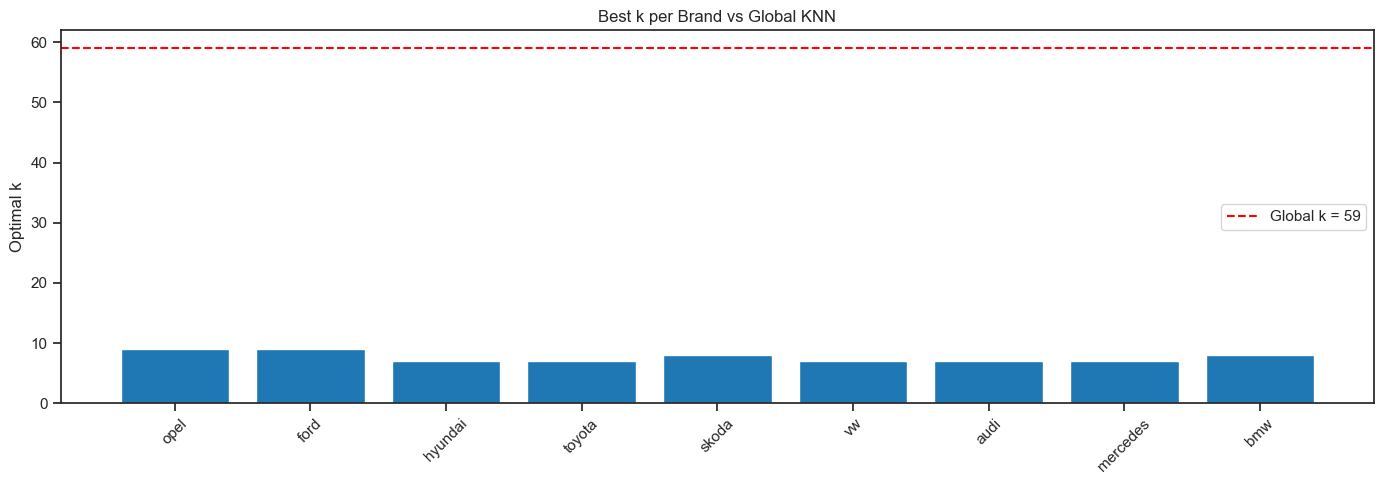

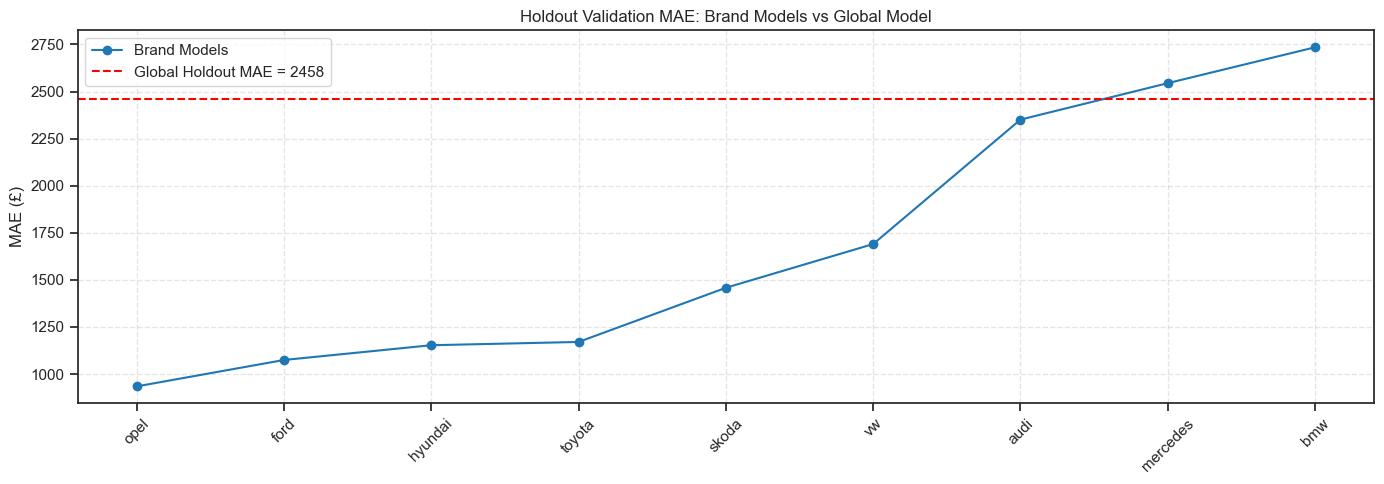

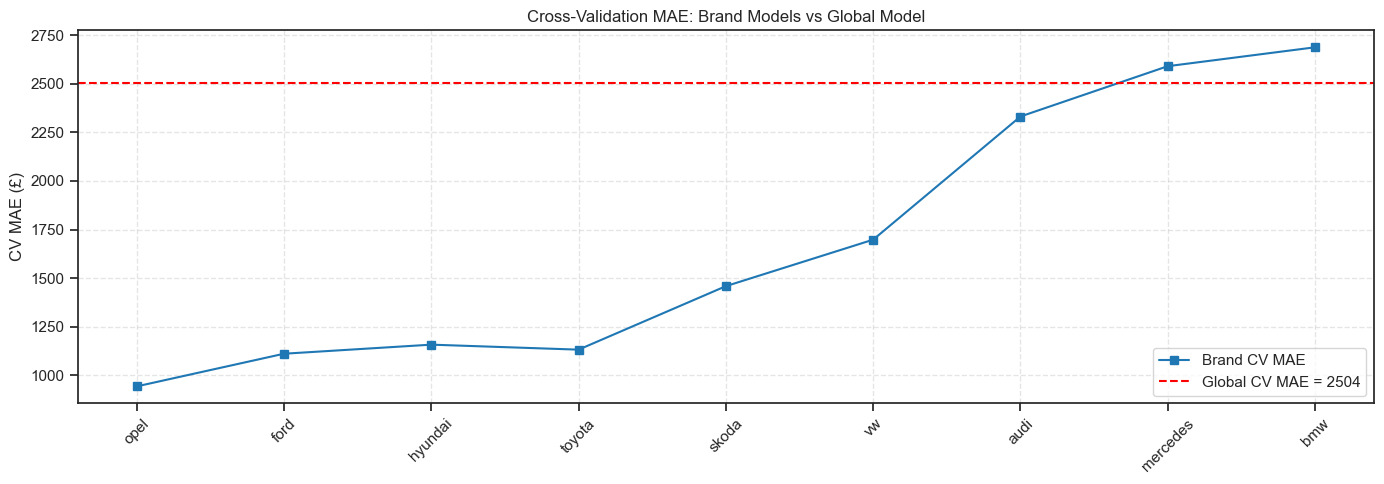

In [91]:
# -------------------------------
# Global model performance values
# -------------------------------
global_k = 59  # From global KNN model
global_val_mae = 2458.21
global_cv_val_mae = 2503.57

import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------
# Build comparison table: brands vs global
# -------------------------------------
comparison_rows = []

for brand, res in brand_knn_results.items():
    comparison_rows.append({
        "Brand": brand,
        "Best k (Brand)": res["best_k"],
        "Train MAE (Brand)": res["train_MAE"],
        "Val MAE (Brand)": res["val_MAE"],
        "Overfit Gap (Brand)": res["overfitting_gap"],
        "CV Train MAE (Brand)": res["cv_train_mae"],
        "CV Val MAE (Brand)": res["cv_val_mae"],
        # Add global values
        "Global k": global_k,
        "Global Val MAE": global_val_mae,
        "Global CV Val MAE": global_cv_val_mae,
    })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df = comparison_df.sort_values("Val MAE (Brand)").reset_index(drop=True)

display(comparison_df)

# ---------------------------------------------------
# Plot 1 — Best k per brand vs Global k
# ---------------------------------------------------
plt.figure(figsize=(14, 5))
plt.bar(comparison_df["Brand"], comparison_df["Best k (Brand)"])
plt.axhline(global_k, color="red", linestyle="--", label=f"Global k = {global_k}")

plt.title("Best k per Brand vs Global KNN")
plt.ylabel("Optimal k")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 2 — Holdout MAE comparison
# ---------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(
    comparison_df["Brand"], 
    comparison_df["Val MAE (Brand)"], 
    marker="o", 
    label="Brand Models"
)
plt.axhline(
    global_val_mae, 
    color="red", 
    linestyle="--", 
    label=f"Global Holdout MAE = {global_val_mae:.0f}"
)

plt.title("Holdout Validation MAE: Brand Models vs Global Model")
plt.ylabel("MAE (£)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 3 — Cross-validation MAE comparison
# ---------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(
    comparison_df["Brand"], 
    comparison_df["CV Val MAE (Brand)"], 
    marker="s", 
    label="Brand CV MAE"
)
plt.axhline(
    global_cv_val_mae, 
    color="red", 
    linestyle="--", 
    label=f"Global CV MAE = {global_cv_val_mae:.0f}"
)

plt.title("Cross-Validation MAE: Brand Models vs Global Model")
plt.ylabel("CV MAE (£)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Fitting Final Pipelines for Each Brand

This block creates **brand-specific final pipelines** using the full dataset for each brand:

1. **Iterate over each brand** in the dataset.
2. **Extract full brand data** including the `'Brand'` column.
3. **Handle missing transmission values**:
   - Sanitize unexpected transmission entries.  
   - Fill missing values using the mode from the full brand data.
4. **Fit preprocessing pipeline** (`encoder`, `scaler`, `imputer`) on the full brand dataset.
5. **Transform the full brand dataset** using the fitted preprocessing objects.
6. **Prepare features for modeling** by removing the `'Brand'` column.
7. **Fit the final KNN model**:
   - Use the optimal `k` determined earlier, adjusted if the number of samples is small.
8. **Store the complete pipeline** in `brand_pipelines`:
   - Preprocessing objects, final model, and transmission mode.  

These pipelines are ready for making predictions on new or tes


In [84]:
brand_pipelines = {}

print("\n----- Fitting final pipelines for each brand (using FULL brand data) -----\n")
for brand in tqdm(brands):
    print(f"\nFitting final pipeline for brand: {brand}")
    # Example corrected snippet for final pipeline fitting:
    mask = (X_M['Brand'] == brand)
    X_brand_full = X_M.loc[mask].reset_index(drop=True).copy()   # includes Brand
    y_brand_full = y_M.loc[mask].reset_index(drop=True).copy()

    X_no_brand = X_brand_full.drop(columns=['Brand']).copy()

    # find transmission mode from full brand set (used to fill missing if any)
    if 'transmission' in X_no_brand.columns:

        # NEW: sanitize unexpected trans values
        allowed_trans = ['automatic', 'manual', 'semi-auto']
        X_no_brand.loc[~X_no_brand['transmission'].isin(allowed_trans), 'transmission'] = np.nan

        transmission_mode_full = X_no_brand['transmission'].mode().iloc[0]

        if X_no_brand['transmission'].isna().any():
            X_no_brand['transmission'] = X_no_brand['transmission'].fillna(transmission_mode_full)

    else:
        transmission_mode_full = None

    # Fit preproc/scaler/imputer on FULL raw brand data
    preproc_full, scaler_full, imputer_full, X_brand_processed_first = build_and_fit_preprocessor(
        X_no_brand, transmission_mode_full
    )

    # Now rebuild a proper raw dataframe INCLUDING Brand for transformation
    X_full_raw_for_transform = X_brand_full.copy().reset_index(drop=True)

    # Transform using the same objects
    X_brand_processed = transform_with_preproc(preproc_full, scaler_full, imputer_full, X_full_raw_for_transform)

    # Ready for model (remove Brand)
    X_brand_model = X_brand_processed.drop(columns=['Brand'], errors='ignore')

    # fit final model
    n_samples_full = X_brand_model.shape[0]
    if n_samples_full < 2:
        print(f"Skipping final model for brand {brand}: only {n_samples_full} samples.")
        continue
    k_final = brand_knn_results[brand]['best_k']
    k_final = min(k_final, max(1, n_samples_full - 1))    
    model = KNeighborsRegressor(n_neighbors=k_final, weights='uniform', n_jobs=-1)
    model.fit(X_brand_model, y_brand_full)

    # store the final objects (we will use these to predict on true test)
    brand_pipelines[brand] = {
        'preproc': preproc_full,
        'scaler': scaler_full,
        'imputer': imputer_full,
        'model': model,
        'transmission_mode': transmission_mode_full
    }

    print(f"Stored final pipeline for {brand} (k={k_final})")

print("\nAll final brand pipelines fitted.")




----- Fitting final pipelines for each brand (using FULL brand data) -----



  0%|          | 0/9 [00:00<?, ?it/s]


Fitting final pipeline for brand: audi


 11%|█         | 1/9 [00:00<00:02,  2.90it/s]

Stored final pipeline for audi (k=7)

Fitting final pipeline for brand: bmw


 22%|██▏       | 2/9 [00:00<00:02,  2.90it/s]

Stored final pipeline for bmw (k=8)

Fitting final pipeline for brand: ford


 44%|████▍     | 4/9 [00:11<00:15,  3.02s/it]

Stored final pipeline for ford (k=9)

Fitting final pipeline for brand: hyundai
Stored final pipeline for hyundai (k=7)

Fitting final pipeline for brand: mercedes


 56%|█████▌    | 5/9 [00:16<00:15,  3.94s/it]

Stored final pipeline for mercedes (k=7)

Fitting final pipeline for brand: opel


 78%|███████▊  | 7/9 [00:17<00:03,  1.94s/it]

Stored final pipeline for opel (k=9)

Fitting final pipeline for brand: skoda
Stored final pipeline for skoda (k=8)

Fitting final pipeline for brand: toyota


 89%|████████▉ | 8/9 [00:17<00:01,  1.40s/it]

Stored final pipeline for toyota (k=7)

Fitting final pipeline for brand: vw


100%|██████████| 9/9 [00:18<00:00,  2.07s/it]

Stored final pipeline for vw (k=7)

All final brand pipelines fitted.


## Prediction

### Function: Preprocess Full Dataset

`preprocess_full_dataset` reproduces the **final preprocessing pipeline** applied during modeling, ensuring new data matches the format used for training.  

- **Inputs**:
  - `df_raw`: Raw input DataFrame.  
  - `dict_brand_mapping`, `dict_transmission_mapping`: Dictionaries for categorical normalization.  
  - `mode_transmission`: Most frequent transmission type for filling missing values.  
  - `encoder`, `scaler`, `imputer`: Fitted preprocessing objects from training.  

- **Process**:
  1. Clean text inconsistencies and normalize strings.  
  2. Map brands and transmission types to consistent categories.  
  3. Remove unwanted columns.  
  4. Fix numeric columns (convert, take absolute values, clip/round as needed).  
  5. Feature engineering: create `Years_old` from `year`.  
  6. Fill missing `transmission` values using `mode_transmission`.  
  7. Apply saved **OHE encoder**, **scaler**, and **KNN imputer**.  
  8. Reattach the `'Brand'` column.  

- **Output**:
  - Fully preprocessed DataFrame ready for brand-specific modeling.


In [85]:
def preprocess_full_dataset(df_raw,
                            dict_brand_mapping,
                            dict_transmission_mapping,
                            mode_transmission,
                            encoder,
                            scaler,
                            imputer):
    """
    This function reproduces EXACTLY your final preprocessing pipeline.
    - fix text
    - apply brand/transmission mapping
    - clean numerics
    - remove unwanted columns
    - feature engineering
    - mode imputation for transmission
    - OHE encoding (using saved encoder)
    - scaling (using saved scaler)
    - KNN imputation (using saved imputer)
    """
    df = df_raw.copy()

    # CLEAN TEXT INCONSISTENCIES
    # -------------------------------------------
    df = df.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)

    # brand mapping
    for key, values in dict_brand_mapping.items():
        df.loc[df['Brand'].isin(values), 'Brand'] = key

    # transmission mapping
    for key, values in dict_transmission_mapping.items():
        df.loc[df['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan

    # REMOVE UNWANTED COLUMNS
    # -------------------------------------------
    drop_cols = ['model', 'tax', 'previousOwners', 'fuelType',
                 'paintQuality%', 'hasDamage']
    
    df = df.drop(columns=drop_cols, errors='ignore')

    # FIX NUMERIC COLUMNS
    # -------------------------------------------
    numeric_cols = ['mileage','mpg','engineSize']

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').abs()
    
    df.loc[df['engineSize'] < 0.9, 'engineSize'] = 0.9
    df['year'] = df['year'].round().astype("Int64")
    df['year'] = df['year'].clip(upper=2020)

    # FEATURE ENGINEERING
    # -------------------------------------------
    df['Years_old'] = 2021 - df['year']
    df = df.drop(columns=['year'])

    # MODE IMPUTATION (transmission)
    # -------------------------------------------
    df['transmission'].fillna(mode_transmission, inplace=True)

    # SAVE BRAND COLUMN FOR LATER
    # -------------------------------------------
    brands = df['Brand']
    df = df.drop(columns=['Brand'])

    # APPLY ENCODER (OHE)
    # -------------------------------------------
    df_encoded = encoder.transform(df)

    # SCALE
    # -------------------------------------------
    df_scaled = scaler.transform(df_encoded)

    # KNN IMPUTE
    # -------------------------------------------
    df_imputed = imputer.transform(df_scaled)

    # REBUILD DF
    # -------------------------------------------
    df_final = pd.DataFrame(df_imputed, columns=df_encoded.columns)
    df_final['Brand'] = brands.values

    return df_final


### Function: Predict Prices for All Brands

`predict_all_brands` generates predictions for each brand in a new dataset using the **brand-specific pipelines and models**.  

- **Inputs**:
  - `df_raw`: Raw DataFrame with features including `'Brand'` and `'transmission'`.  
  - `brand_pipelines`: Dictionary containing final pipelines and models for each brand.  
  - `dict_brand_mapping`, `dict_transmission_mapping`: Mapping dictionaries for cleaning categorical variables.  

- **Process**:
  1. Clean text and normalize brand and transmission values.  
  2. Loop over all brands present in the dataset:
     - Skip brands without a trained pipeline.  
     - Fill missing `transmission` with the brand-specific mode.  
     - Preprocess data using `preprocess_full_dataset` with the saved pipeline.  
     - Predict log-prices using the brand-specific KNN model.  
     - Convert predictions back to the original price scale.  
  3. Collect predictions for all brands into a single DataFrame.  

- **Output**:
  - DataFrame containing the original features plus a new column `PredictedPrice`.


In [86]:
def predict_all_brands(df_raw, brand_pipelines, dict_brand_mapping, dict_transmission_mapping):
    df = df_raw.copy()
    df = df.reset_index(drop=True)

    all_predictions = []

    # ensure text normalization & brand mapping (same deterministic cleaning you used)
    df = df.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)
    for key, values in dict_brand_mapping.items():
        df.loc[df['Brand'].isin(values), 'Brand'] = key
    for key, values in dict_transmission_mapping.items():
        df.loc[df['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan

    allowed_trans = ['automatic', 'manual', 'semi-auto']
    df.loc[~df['transmission'].isin(allowed_trans), 'transmission'] = np.nan

    # Extract valid brands (drop NaN, convert everything to string)
    brands_in_test = df['Brand'].dropna().astype(str).unique()

    # Sort safely (now all values are strings)
    brands_in_test = np.sort(brands_in_test)

    # Loop through brands
    for brand in brands_in_test:        
        if brand not in brand_pipelines:
            # No model for this brand — skip
            continue

        mask = df['Brand'] == brand
        df_brand_raw = df.loc[mask].copy().reset_index(drop=True)

        pipeline = brand_pipelines[brand]
        preproc = pipeline['preproc']
        scaler = pipeline['scaler']
        imputer = pipeline['imputer']
        model = pipeline['model']
        mode_trans = pipeline['transmission_mode']

        # Ensure transmission missing filled with mode used at training time
        if 'transmission' in df_brand_raw.columns and mode_trans is not None:
            df_brand_raw['transmission'] = df_brand_raw['transmission'].fillna(mode_trans)

        X_proc = preprocess_full_dataset(
            df_raw=df_brand_raw,
            dict_brand_mapping=dict_brand_mapping,
            dict_transmission_mapping=dict_transmission_mapping,
            mode_transmission=mode_trans,
            encoder=preproc,
            scaler=scaler,
            imputer=imputer
        )
        X_for_model = X_proc.drop(columns=['Brand'], errors='ignore')

        # predict log-price, then convert to original scale
        y_pred_log = model.predict(X_for_model)
        y_pred_orig = np.exp(y_pred_log)

        df_brand_raw['PredictedPrice'] = y_pred_orig
        all_predictions.append(df_brand_raw)

    if len(all_predictions) == 0:
        return pd.DataFrame(columns=list(df.columns) + ['PredictedPrice'])

    final_df = pd.concat(all_predictions).sort_index()
    return final_df



### Predicting Prices on Test Data

1. **Load the test dataset** from `test.csv`.  
2. **Generate predictions** for each brand using `predict_all_brands` and the previously fitted brand-specific pipelines.  
3. **Output**:
   - `predicted_df`: Test DataFrame with all original features plus a new column `PredictedPrice`.  

This step produces the final price predictions for all cars in the test set.


In [87]:
print("\n----- Predicting on test.csv -----\n")
test_df_raw = pd.read_csv(TEST_CSV)
predicted_df = predict_all_brands(test_df_raw, brand_pipelines, dict_brand_mapping, dict_transmission_mapping)

# Preview
print(predicted_df.head())


----- Predicting on test.csv -----

    carID   Brand   model    year transmission       mileage fuelType    tax  \
0   76189    audi      tt  2017.0       manual  30562.000000   diesel  145.0   
0   85391    ford  fiesta  2018.0       manual  29626.000000   petrol  145.0   
0   98302  toyota    aygo  2017.0       manual  13255.000000   petrol  145.0   
0   96210   skoda  superb  2019.0       manual  20632.000000   diesel  145.0   
0  106581      vw  tiguan  2017.0    semi-auto -48190.655673   petrol  150.0   

    mpg  engineSize  paintQuality%  previousOwners  hasDamage  PredictedPrice  
0  62.8         2.0            NaN             1.0        0.0    17532.479751  
0  65.7         1.0           64.0             1.0        0.0    10702.182325  
0  69.0         1.0           35.0             3.0        0.0     7699.654769  
0  64.2         2.0           99.0             3.0        0.0    16550.975403  
0  38.2         2.0           60.0             2.0        0.0    21504.233498  
  